In [17]:
import numpy as np
import librosa
import soundfile as sf
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve


In [18]:
# Load impulse response
ir_path = 'audio/impulse_response.wav'
ir, ir_sr = librosa.load(ir_path, sr=None)

# Load dry input
dry_path = 'audio/dry_audio.wav'
dry, dry_sr = librosa.load(dry_path, sr=None)

print(f"IR sample rate: {ir_sr}, Dry sample rate: {dry_sr}")


IR sample rate: 48000, Dry sample rate: 48000


In [19]:
if ir_sr != dry_sr:
    ir = librosa.resample(ir, orig_sr=ir_sr, target_sr=dry_sr)
    ir_sr = dry_sr


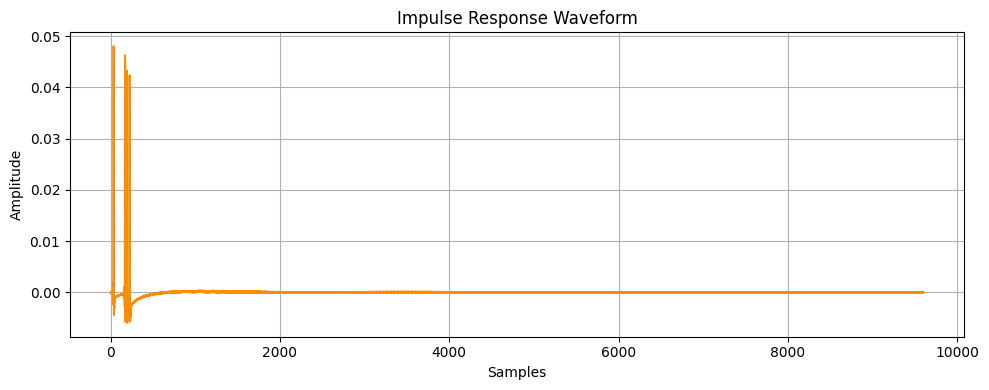

In [20]:
plt.figure(figsize=(10, 4))
plt.plot(ir, color='darkorange')
plt.title("Impulse Response Waveform")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()


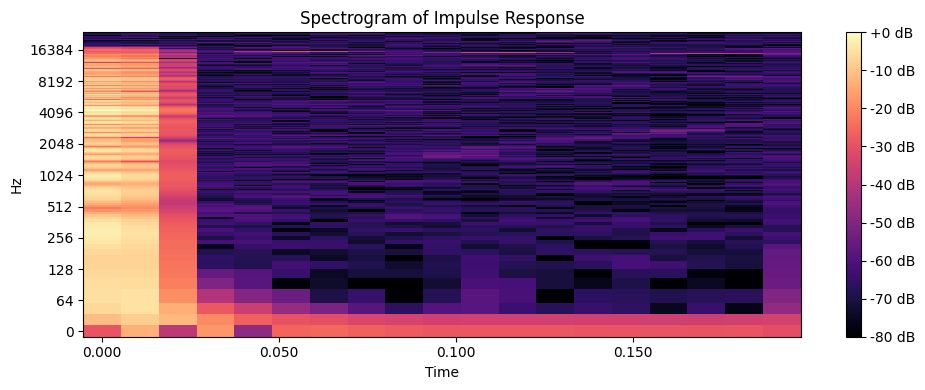

In [21]:
plt.figure(figsize=(10, 4))
D = librosa.amplitude_to_db(np.abs(librosa.stft(ir)), ref=np.max)
librosa.display.specshow(D, sr=ir_sr, x_axis='time', y_axis='log', cmap='magma')
plt.title('Spectrogram of Impulse Response')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

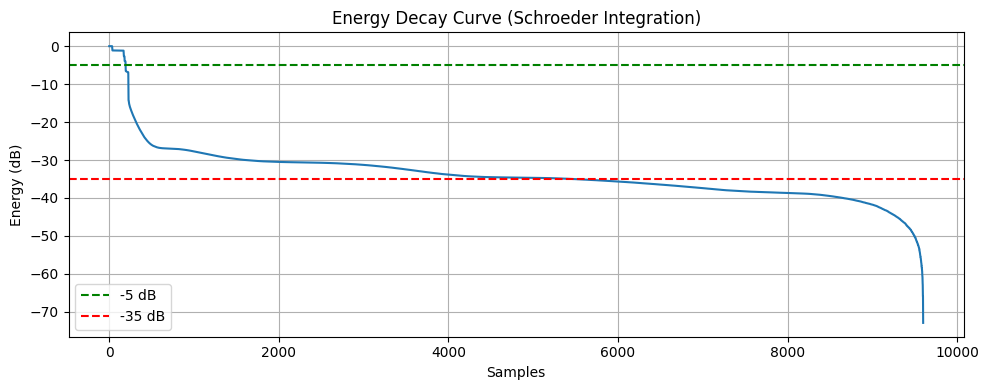

Estimated RT60: 0.219 seconds


In [22]:
def estimate_rt60(ir, sr):
    energy = np.cumsum(ir[::-1] ** 2)[::-1]  # Schroeder integration
    energy_db = 10 * np.log10(energy / np.max(energy))
    
    # Find -5 dB and -35 dB points for T30 (then extrapolate RT60)
    try:
        t = np.arange(len(energy_db)) / sr
        t_start = t[np.where(energy_db <= -5)[0][0]]
        t_end = t[np.where(energy_db <= -35)[0][0]]
        rt60 = (t_end - t_start) * 2  # T30 extrapolated to RT60
    except IndexError:
        rt60 = None

    return rt60, energy_db

rt60, energy_db = estimate_rt60(ir, ir_sr)

plt.figure(figsize=(10, 4))
plt.plot(energy_db)
plt.axhline(-5, color='green', linestyle='--', label='-5 dB')
plt.axhline(-35, color='red', linestyle='--', label='-35 dB')
plt.title('Energy Decay Curve (Schroeder Integration)')
plt.xlabel('Samples')
plt.ylabel('Energy (dB)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Estimated RT60: {rt60:.3f} seconds" if rt60 else "Could not estimate RT60")


In [23]:
# Convolve using FFT for speed
wet = fftconvolve(dry, ir, mode='full')

# Normalize
wet /= np.max(np.abs(wet))

# Trim or fade if needed (optional)


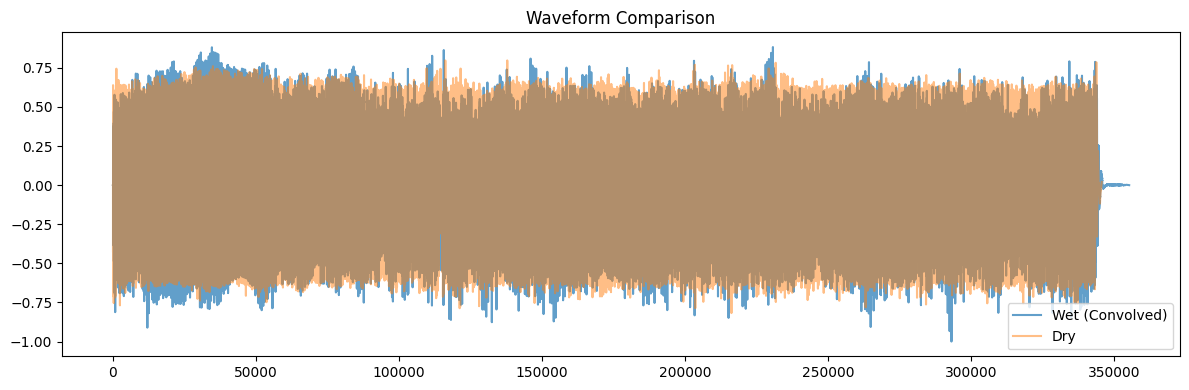

In [24]:
# Plot waveforms
plt.figure(figsize=(12, 4))
plt.plot(wet, alpha=0.7, label='Wet (Convolved)')
plt.plot(dry, alpha=0.5, label='Dry')
plt.title('Waveform Comparison')
plt.legend()
plt.tight_layout()
plt.show()


In [25]:
sf.write('audio/output_wet.wav', wet, dry_sr)
print("Saved output to audio/output_wet.wav")


Saved output to audio/output_wet.wav
